In [1]:
# Import Python 3's print function and division
from __future__ import print_function, division
import os
from numpy import *
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Tell GDAL to throw Python exceptions, and register all drivers
import numba

In [2]:
def norm(band):
    band_min, band_max = band.min(), band.max()
    return ((band - band_min)/(band_max - band_min))

In [3]:
def CreateGeoTiff(Name, Array, DataType, NDV, bandnames=None, ref_image=None, GeoT=None, Projection=None):
    # If it's a 2D image we fake a third dimension:
    if len(Array.shape) == 2:
        Array = np.array([Array])
    if ref_image == None and (GeoT == None or Projection == None):
        raise RuntimeWarning('ref_image or settings required.')
    if bandnames != None:
        if len(bandnames) != Array.shape[0]:
            raise RuntimeError('Need {} bandnames. {} given'
                               .format(Array.shape[0], len(bandnames)))
    else:
        bandnames = ['Band {}'.format(i+1) for i in range(Array.shape[0])]
    if ref_image != None:
        refimg = gdal.Open(ref_image)
        GeoT = refimg.GetGeoTransform()
        Projection = refimg.GetProjection()
    driver = gdal.GetDriverByName('GTIFF')
    Array[np.isnan(Array)] = NDV
    DataSet = driver.Create(
        Name, Array.shape[2], Array.shape[1], Array.shape[0], DataType)
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection(Projection)
    for i, image in enumerate(Array, 1):
        DataSet.GetRasterBand(i).WriteArray(image)
        DataSet.GetRasterBand(i).SetNoDataValue(NDV)
        DataSet.SetDescription(bandnames[i-1])
    DataSet.FlushCache()
    return Name

In [4]:
# next setup a colormap for our map
colors = dict((
    (0, (0, 0, 0, 255)),  # No data
    (1, (0, 255, 0, 255)),   # Green - C Water H
    (2, (255, 0, 0, 255)),  # Lime - Other Vegatation
    (3, (0, 0, 255, 255)),   # Blue - Water L
    (4, (255, 255, 0, 255)),   # Blue - Water D
    (5, (255, 0, 255, 255)),   # Tan - Forest
     (6, (0, 255, 255, 255)),   # Tan - Forest
     (7, (255, 255, 255, 255)),   # Tan - Forest
))

n = 8
# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v

index_colors = [colors[key] if key in colors else
                (255, 255, 255, 0) for key in range(0, n+1)]

cmap = plt.matplotlib.colors.ListedColormap(
    index_colors, 'Classification', n+1)

In [5]:
def read_band_image(path,dronedata):
    """
    This function takes as input the ldrone image and the path of the 
    folder that the images are stored, reads the image and returns the data as
    an array
    input:   drone          drone image
             path           string            path ,of the folder
    output:  data           array (n x m)     array of the band image
             spatialRef     string            projection 
             geoTransform   tuple             affine transformation coefficients
             targetprj                        spatial reference
    """
    import os
    import rasterio

    
    os.chdir(path)
    os.getcwd()
    img_ds=rasterio.open(dronedata)
    data = np.zeros((img_ds.height, img_ds.width, img_ds.count))
                   

    for b in range(data.shape[2]):
        data[:, :, b] = np.array(img_ds.read(b+1))
    crs=img_ds.crs
    
    geoTransform = img_ds.transform
    return data, crs, geoTransform

In [6]:
def visRGB(img1, img2, img3,
           title = 'RGB image',
           scale1 = [],
           scale2 = [],
           scale3 = [],
           flag = 0, outall = ''):
    """
    Visualise the RGB of a single acquisition
    """           
    if scale1 == []:
       scale1 = img1
    if scale2 == []:
       scale2 = img2
    if scale3 == []:
       scale3 = img3

    size = np.shape(img1)           
    iRGB = np.zeros([size[0],size[1],3])
    iRGB[:,:,0] = np.abs(img1)/(np.abs(scale1).mean()*1.5)
    iRGB[:,:,1] = np.abs(img2)/(np.abs(scale2).mean()*1.5)
    iRGB[:,:,2] = np.abs(img3)/(np.abs(scale3).mean()*1.5)
    iRGB[np.abs(iRGB) > 1] = 1
            
#    plt.figure()

    fig = plt.figure(figsize=(8,8))
    ax2 = fig.add_subplot(1,1,1)
    plot = plt.imshow(iRGB); 
    plt.title('(RGB image)'); 
    cbar = plt.colorbar(plot,aspect=20); plt.set_cmap('gist_earth'); 
    cbar.set_label('Reflectance',rotation=90,labelpad=20); 
    ax2.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
    rotatexlabels = plt.setp(ax2.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

    if flag == 1:
        fig.savefig(outall)

    return       
           

In [ ]:
GTdirectory

In [7]:
datadirectory='/space/vak/Weedwatch/Patancheru/Drone/Images/'
GTdirectory='/space/vak/Weedwatch/Patancheru/Drone/GT/Anoop Labels/Rasterized/'

imagefile_1 = 'Orthomosaic_28Jan2021_PatanCheru_AOI.tif'
GTfile_1 = 'GT_Orthophoto_28Jan2021_5cm_AOI.tif'
(img1, crs, geoTransform) = read_band_image(datadirectory,imagefile_1)
(gt1,crs, geoTransform) = read_band_image(GTdirectory,GTfile_1)


imagefile_2 = 'Orthomosaic_15Feb2021_PatanCheru_AOI.tif'
GTfile_2 = 'GT_Orthophoto_15Feb2021_5cm_AOI.tif'
(img2, crs, geoTransform) = read_band_image(datadirectory,imagefile_2)
(gt2,crs, geoTransform) = read_band_image(GTdirectory,GTfile_2)

imagefile_3 = 'Orthomosaic_26Mar2021_PatanCheru_AOI.tif'
GTfile_3 = 'GT_Orthophoto_26Mar2021_5cm_AOI.tif'
(img3, crs, geoTransform) = read_band_image(datadirectory,imagefile_3)
(gt3,crs, geoTransform) = read_band_image(GTdirectory,GTfile_3)

imagefile_4 = 'Orthomosaic_06June2021_Patancheru_AOI.tif'
GTfile_4 = 'GT_Orthophoto_06Jun2021_5cm_AOI.tif'
(img4, crs, geoTransform) = read_band_image(datadirectory,imagefile_4)
(gt4,crs, geoTransform) = read_band_image(GTdirectory,GTfile_4)

In [145]:
img1.shape, img2.shape, img4.shape

((25907, 17101, 6), (25907, 17101, 6), (25907, 17101, 6))

In [ ]:
visRGB(img1[:,:,0], img1[:,:,4], img1[:,:,1],
           title = 'RGB image',
           scale1 = [0,10000],
           scale2 = [0,20000],
           scale3 = [0,10000],
           flag = 0, outall = '')

In [ ]:
visRGB(img2[:,:,0], img2[:,:,4], img2[:,:,1],
           title = 'RGB image',
           scale1 = [0,10000],
           scale2 = [0,20000],
           scale3 = [0,10000],
           flag = 0, outall = '')

In [ ]:
visRGB(img4[:,:,0], img4[:,:,4], img4[:,:,1],
           title = 'RGB image',
           scale1 = [0,30000],
           scale2 = [0,50000],
           scale3 = [0,20000],
           flag = 0, outall = '')

In [7]:
import tensorflow
tensorflow.test.is_gpu_available()

2023-05-25 12:52:00.888709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-05-25 12:52:04.754323: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


False

In [ ]:
img3.shape, gt3.shape

In [141]:
pwd

'/space/vak/Weedwatch/Patancheru/Drone/Images'

In [11]:

np.savez('myfileforML_WH.npz', X=X, y=y)

In [7]:
GTdirectory='/space/vak/Weedwatch/Patancheru/Drone/GT/Anoop Labels/Rasterized/'


In [8]:
os.chdir(GTdirectory)
os.getcwd()
data =load('myfileforML_WH.npz')

X=data['X']
y=data['y']

In [9]:
X.shape, y.shape

((40385, 5), (40385,))

In [10]:
y[y > 3] = 0
y[y == 1] = 0
y[y == 3] = 2

In [27]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=0)


classifier='SGD'
if classifier=='RF':
    model = RandomForestClassifier(n_estimators=500, max_depth=20,oob_score=True)
# Fit our model to training data
elif classifier=='DT':
    model = ExtraTreesClassifier(max_depth=6)
elif classifier=='kNN':
    model = KNeighborsClassifier(n_neighbors=8)
elif classifier== 'LR':
    model = LogisticRegression()
elif classifier== 'SGD':
    model = SGDClassifier()
elif classifier=='GB':
    model = GradientBoostingClassifier(n_estimators=1200)    
elif classifier=='GNB':
    model = GaussianNB()
elif classifier== 'MNB':
    model = MultinomialNB()

elif classifier=='SVM':
    model = svm.SVC(decision_function_shape = "ovr")# ovo
elif classifier== 'MLP':
    print('MLP')
    model = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)

 # Fit our model to training data
model = model.fit(X_train, y_train) 

In [13]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=model.oob_score_ * 100))

Our OOB prediction of accuracy is: 95.48335974643423%


In [12]:
bands = [1, 2, 3, 4, 5,]

for b, imp in zip(bands, model.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

AttributeError: 'MLPClassifier' object has no attribute 'feature_importances_'

In [28]:
# Define the plotting function
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, ylabel='True label', xlabel='Predicted label', filename=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2, suppress=True)

    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)
                                   [:, np.newaxis] + np.finfo(np.float).eps)

    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title, fontsize=20)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

    plt.tight_layout()
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)

In [29]:
import pandas as pd

# Setup a dataframe -- just like R
df = pd.DataFrame()
df['truth'] = y_test
y_pred = model.predict(X_test)

df['predict'] = y_pred

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict     0     2    All
truth                     
0        5851  1245   7096
2         665  2336   3001
All      6516  3581  10097


In [95]:
import pandas as pd

# Setup a dataframe -- just like R
df = pd.DataFrame()
df['truth'] = y_test
y_pred = model.predict(X_test)

df['predict'] = y_pred

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict     1     2     3     4     5     6     7    All
truth                                                   
1        1432     3     0    36     9     3     1   1484
2          15  1656    96    39     9     0   116   1931
3           0    86   973     1     0     0    10   1070
4          58    85    10  1396    23    17   164   1753
5          11     4     0    21   839   273    30   1178
6           4     1     0    18   178   957    23   1181
7           0   156    22   108    24    32  1158   1500
All      1520  1991  1101  1619  1082  1282  1502  10097


In [96]:
y_pred

array([7, 6, 4, ..., 6, 2, 5], dtype=uint8)

In [19]:
# Misc
import pickle
import sys
import os
import datetime
import itertools
# from tqdm import tqdm_notebook as tqdm
import enum
import matplotlib as mpl
from sklearn import preprocessing

In [20]:
class LULC(enum.Enum):
    NO_DATA = (0,  'Others',           'white')
    W=    (1,  'W',         'xkcd:Blue')
    WH1 = (2,  'WH',         'xkcd:Green')
    WH2 = (3,  'WH2',  'xkcd:Lime')
    OV =  (4,  'OV',           'xkcd:Blue')
    B = (5,  'B',        'xkcd:Blue')
    S= (6,  'S',        'xkcd:Blue')
    TV = (7,  'TV',        'xkcd:Blue')
    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3


# example usecase
# LULC.BARELAND.id   # return 9
# Reference colormap things
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])
lulc_norm = mpl.colors.BoundaryNorm(np.arange(-0.5, 8, 1), lulc_cmap.N)

In [21]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
class_labels = np.unique(y_test)
class_names = [entry.class_name for entry in LULC]

/tmp/ipykernel_570935/3900164669.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  [:, np.newaxis] + np.finfo(np.float).eps)


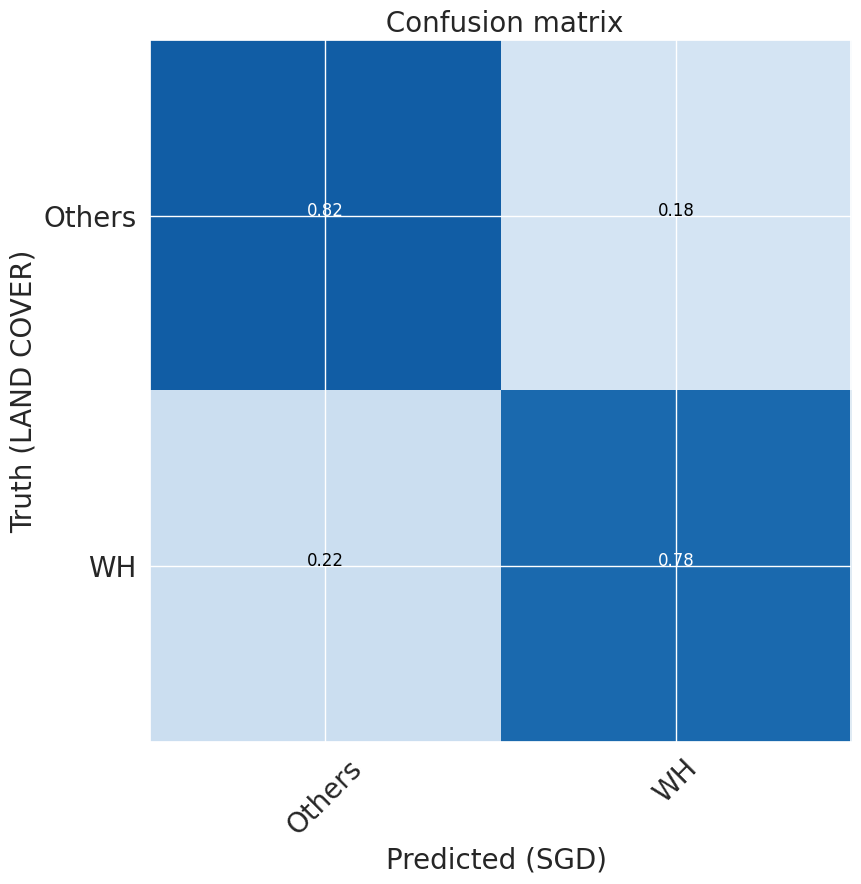

In [30]:
from sklearn import metrics
class_labels = np.unique(y_test)
class_names = [entry.class_name for entry in LULC]
fig = plt.figure(figsize=(9, 9), dpi=100)

conf_matrix_gbm = metrics.confusion_matrix(np.float64(y_test), np.float64(y_pred))
plot_confusion_matrix(conf_matrix_gbm,
                      classes=[name for idx, name in enumerate(
                          class_names) if idx in class_labels],
                      normalize=True,
                      ylabel='Truth (LAND COVER)',
                      xlabel='Predicted (SGD) ',
                      title=' Confusion matrix')

plt.tight_layout()

/tmp/ipykernel_275399/3900164669.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  [:, np.newaxis] + np.finfo(np.float).eps)


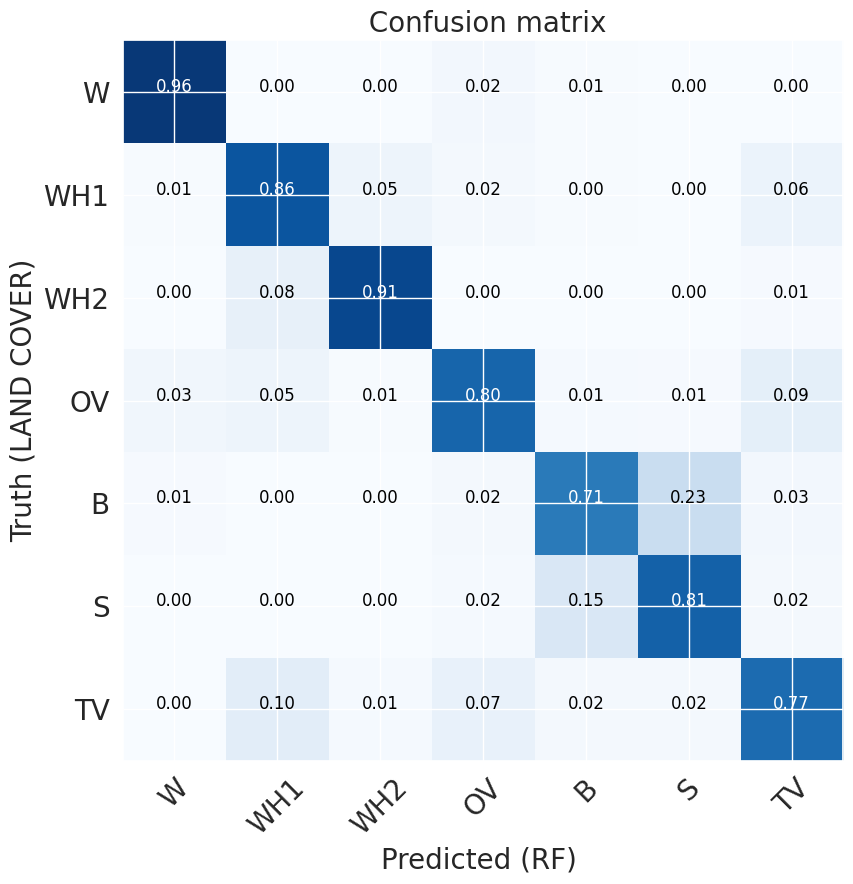

In [100]:
from sklearn import metrics
class_labels = np.unique(y_test)
class_names = [entry.class_name for entry in LULC]
fig = plt.figure(figsize=(9, 9), dpi=100)

conf_matrix_gbm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_matrix_gbm,
                      classes=[name for idx, name in enumerate(
                          class_names) if idx in class_labels],
                      normalize=True,
                      ylabel='Truth (LAND COVER)',
                      xlabel='Predicted (RF) ',
                      title=' Confusion matrix')

plt.tight_layout()

In [90]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.94      0.96      0.95      1484
           2       0.83      0.86      0.84      1931
           3       0.88      0.91      0.90      1070
           4       0.86      0.80      0.83      1753
           5       0.77      0.71      0.74      1178
           6       0.75      0.81      0.78      1181
           7       0.77      0.77      0.77      1500

    accuracy                           0.83     10097
   macro avg       0.83      0.83      0.83     10097
weighted avg       0.83      0.83      0.83     10097



In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      7096
           2       0.92      0.93      0.92      3001

    accuracy                           0.95     10097
   macro avg       0.94      0.95      0.95     10097
weighted avg       0.95      0.95      0.95     10097



In [101]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
import numpy as np

# calculate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

iou_scores = []
for i in range(len(class_labels)):
    true_pos = conf_mat[i, i]
    false_pos = np.sum(conf_mat[:, i]) - true_pos
    false_neg = np.sum(conf_mat[i, :]) - true_pos
    iou = true_pos / (true_pos + false_pos + false_neg)
    iou_scores.append(iou)

print('Kappa coeff. {:.3f}'.format(cohen_kappa_score(y_pred, y_test)))
print('Classification accuracy {:.1f}%'.format(100 * metrics.accuracy_score(y_test, y_pred)))
print('Classification F1-score {:.1f}%'.format(100 * metrics.f1_score(y_test, y_pred, average='weighted')))
f1_scores = metrics.f1_score(y_test, y_pred, labels=class_labels, average=None)
recall = metrics.recall_score(y_test, y_pred, labels=class_labels, average=None)
precision = metrics.precision_score(y_test, y_pred, labels=class_labels, average=None)

print('             Class              =  F1  | Recall | Precision | IoU')
print('         --------------------------------------------------------')
for idx, lulctype in enumerate([class_names[idx] for idx in class_labels]):
    print('         * {0:20s} = {1:2.1f} |  {2:2.1f}  | {3:2.1f}    | {4:2.1f}'.format(lulctype,
                                                                         f1_scores[idx] * 100,
                                                                         recall[idx] * 100,
                                                                         precision[idx] * 100,
                                                                         iou_scores[idx] * 100))


Kappa coeff. 0.804
Classification accuracy 83.3%
Classification F1-score 83.2%
             Class              =  F1  | Recall | Precision | IoU
         --------------------------------------------------------
         * W                    = 95.3 |  96.5  | 94.2    | 91.1
         * WH1                  = 84.4 |  85.8  | 83.2    | 73.1
         * WH2                  = 89.6 |  90.9  | 88.4    | 81.2
         * OV                   = 82.8 |  79.6  | 86.2    | 70.6
         * B                    = 74.2 |  71.2  | 77.5    | 59.0
         * S                    = 77.7 |  81.0  | 74.6    | 63.5
         * TV                   = 77.1 |  77.2  | 77.1    | 62.8


In [25]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
import numpy as np

# calculate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

iou_scores = []
for i in range(len(class_labels)):
    true_pos = conf_mat[i, i]
    false_pos = np.sum(conf_mat[:, i]) - true_pos
    false_neg = np.sum(conf_mat[i, :]) - true_pos
    iou = true_pos / (true_pos + false_pos + false_neg)
    iou_scores.append(iou)

print('Kappa coeff. {:.3f}'.format(cohen_kappa_score(y_pred, y_test)))
print('Classification accuracy {:.1f}%'.format(100 * metrics.accuracy_score(y_test, y_pred)))
print('Classification F1-score {:.1f}%'.format(100 * metrics.f1_score(y_test, y_pred, average='weighted')))
f1_scores = metrics.f1_score(y_test, y_pred, labels=class_labels, average=None)
recall = metrics.recall_score(y_test, y_pred, labels=class_labels, average=None)
precision = metrics.precision_score(y_test, y_pred, labels=class_labels, average=None)

print('             Class              =  F1  | Recall | Precision | IoU')
print('         --------------------------------------------------------')
for idx, lulctype in enumerate([class_names[idx] for idx in class_labels]):
    print('         * {0:20s} = {1:2.1f} |  {2:2.1f}  | {3:2.1f}    | {4:2.1f}'.format(lulctype,
                                                                         f1_scores[idx] * 100,
                                                                         recall[idx] * 100,
                                                                         precision[idx] * 100,
                                                                         iou_scores[idx] * 100))


Kappa coeff. 0.740
Classification accuracy 88.2%
Classification F1-score 88.6%
             Class              =  F1  | Recall | Precision | IoU
         --------------------------------------------------------
         * Others               = 91.0 |  85.2  | 97.8    | 83.5
         * WH                   = 82.8 |  95.4  | 73.1    | 70.6


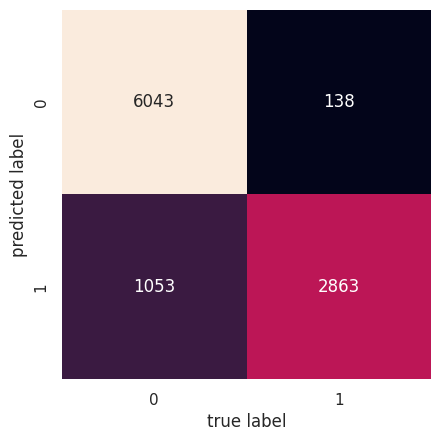

In [26]:


%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()



from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');



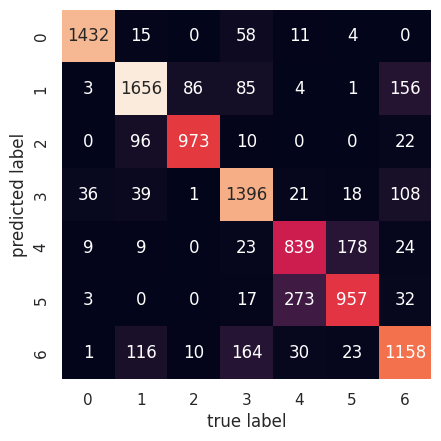

In [102]:


%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()



from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');



# SVM Support Vector Machine Classifier

In [33]:
from sklearn import svm
clf = svm.SVC(decision_function_shape = "ovr")# ovo
model=clf.fit(X_train,y_train)

In [34]:
import pandas as pd

# Setup a dataframe -- just like R
df = pd.DataFrame()
df['truth'] = y_test
y_pred = model.predict(X_test)

df['predict'] = y_pred

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict     1     2     3     4    5     6     7    All
truth                                                  
1        1438     3     0    32    6     4     1   1484
2          16  1606   134    56   29     0    90   1931
3           0    59  1009     0    0     0     2   1070
4         158   121    17  1205   19    10   223   1753
5          35    11     0    49  702   350    31   1178
6           6     2     0    19  124  1010    20   1181
7           2   304    54   106   14    34   986   1500
All      1655  2106  1214  1467  894  1408  1353  10097


/tmp/ipykernel_275399/3900164669.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  [:, np.newaxis] + np.finfo(np.float).eps)


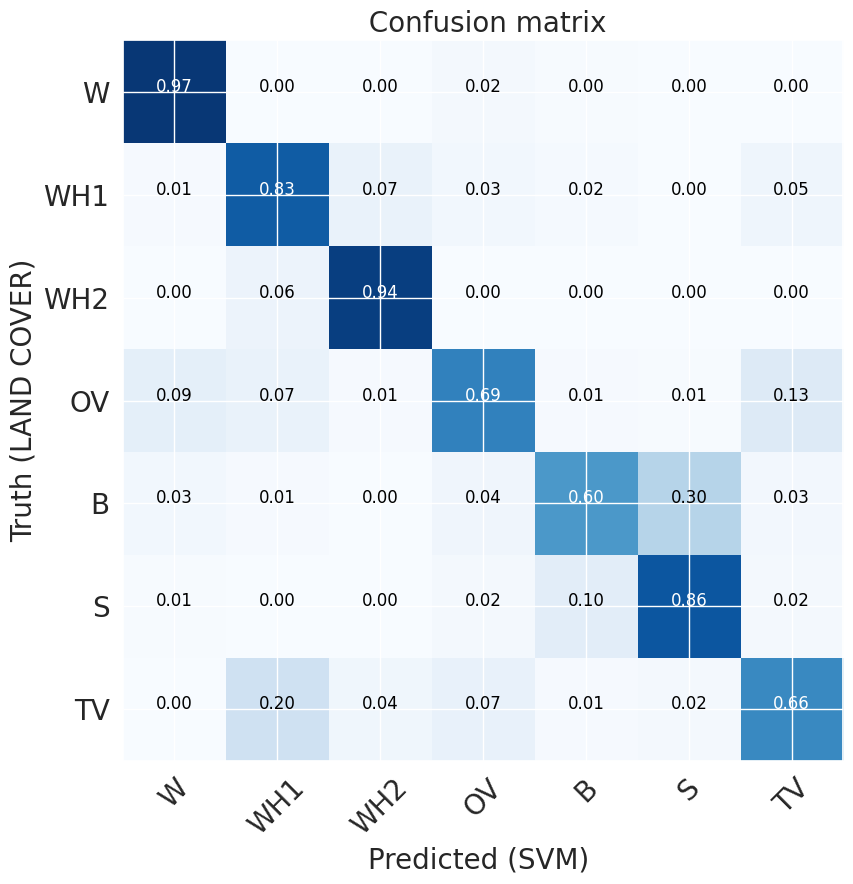

In [35]:


from sklearn import metrics
class_labels = np.unique(y_test)
class_names = [entry.class_name for entry in LULC]
fig = plt.figure(figsize=(9, 9), dpi=100)

conf_matrix_gbm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_matrix_gbm,
                      classes=[name for idx, name in enumerate(
                          class_names) if idx in class_labels],
                      normalize=True,
                      ylabel='Truth (LAND COVER)',
                      xlabel='Predicted (SVM) ',
                      title=' Confusion matrix')

plt.tight_layout()

In [36]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
import numpy as np

# calculate confusion matrix
conf_mat = confusion_matrix(y_test, ysvcpred)

iou_scores = []
for i in range(len(class_labels)):
    true_pos = conf_mat[i, i]
    false_pos = np.sum(conf_mat[:, i]) - true_pos
    false_neg = np.sum(conf_mat[i, :]) - true_pos
    iou = true_pos / (true_pos + false_pos + false_neg)
    iou_scores.append(iou)

print('Kappa coeff. {:.3f}'.format(cohen_kappa_score(ysvcpred, y_test)))
print('Classification accuracy {:.1f}%'.format(100 * metrics.accuracy_score(y_test, ysvcpred)))
print('Classification F1-score {:.1f}%'.format(100 * metrics.f1_score(y_test, ysvcpred, average='weighted')))
f1_scores = metrics.f1_score(y_test, ysvcpred, labels=class_labels, average=None)
recall = metrics.recall_score(y_test, ysvcpred, labels=class_labels, average=None)
precision = metrics.precision_score(y_test, ysvcpred, labels=class_labels, average=None)

print('             Class              =  F1  | Recall | Precision | IoU')
print('         --------------------------------------------------------')
for idx, lulctype in enumerate([class_names[idx] for idx in class_labels]):
    print('         * {0:20s} = {1:2.1f} |  {2:2.1f}  | {3:2.1f}    | {4:2.1f}'.format(lulctype,
                                                                         f1_scores[idx] * 100,
                                                                         recall[idx] * 100,
                                                                         precision[idx] * 100,
                                                                         iou_scores[idx] * 100))


Kappa coeff. 0.751
Classification accuracy 78.8%
Classification F1-score 78.3%
             Class              =  F1  | Recall | Precision | IoU
         --------------------------------------------------------
         * W                    = 91.6 |  96.9  | 86.9    | 84.5
         * WH1                  = 79.6 |  83.2  | 76.3    | 66.1
         * WH2                  = 88.4 |  94.3  | 83.1    | 79.1
         * OV                   = 74.8 |  68.7  | 82.1    | 59.8
         * B                    = 67.8 |  59.6  | 78.5    | 51.2
         * S                    = 78.0 |  85.5  | 71.7    | 64.0
         * TV                   = 69.1 |  65.7  | 72.9    | 52.8


In [45]:
mlp_model = MLPClassifier(activation='tanh', alpha = 0.01, hidden_layer_sizes = 5, solver = 'adam')
mlp = mlp_model.fit(X_train, y_train)
print("train ",mlp.score(X_train,y_train))

print("test: ",mlp.score(X_test,y_test))
y_mlppred = clf.predict(X_test)

train  0.6060486001056524
test:  0.5929484005150044


<BarContainer object of 7 artists>

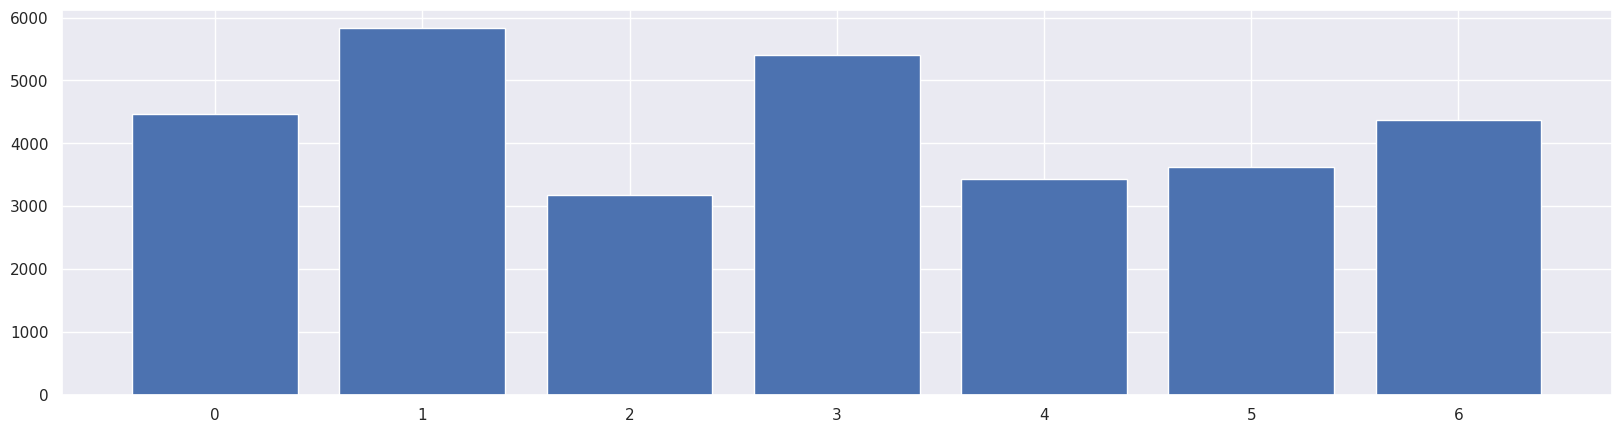

In [46]:
fig = plt.figure(figsize=(20, 5))

label_ids, label_counts = np.unique(y_train, return_counts=True)

plt.bar(range(len(label_ids)), label_counts)



In [27]:
class LULC(enum.Enum):
    NO_DATA = (0,  'No data',           'white')
    W=    (1,  'W',         'blue')
    WH1 = (2,  'WH1',         'Green')
    WH2 = (3,  'WH2',  'Black')
    OV =  (4,  'OV',           'yellow')
    B = (5,  'B',        'Red')
    S= (6,  'S',        'Brown')
    TV = (7,  'TV',        'Pink')
    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3


# example usecase
# LULC.BARELAND.id   # return 9
# Reference colormap things
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])
lulc_norm = mpl.colors.BoundaryNorm(np.arange(-0.5, 8, 1), lulc_cmap.N)

In [28]:
class_labels = np.unique(np.hstack([y_test, y_train]))

scores_test = model.predict_proba(X_test)
labels_binarized = preprocessing.label_binarize(y_test, classes=class_labels)

fpr = dict()
tpr = dict()
roc_auc = dict()

for idx, lbl in enumerate(class_labels):
    fpr[idx], tpr[idx], _ = metrics.roc_curve(
        labels_binarized[:, idx], scores_test[:, idx])
    roc_auc[idx] = metrics.auc(fpr[idx], tpr[idx])

IndexError: index 1 is out of bounds for axis 1 with size 1

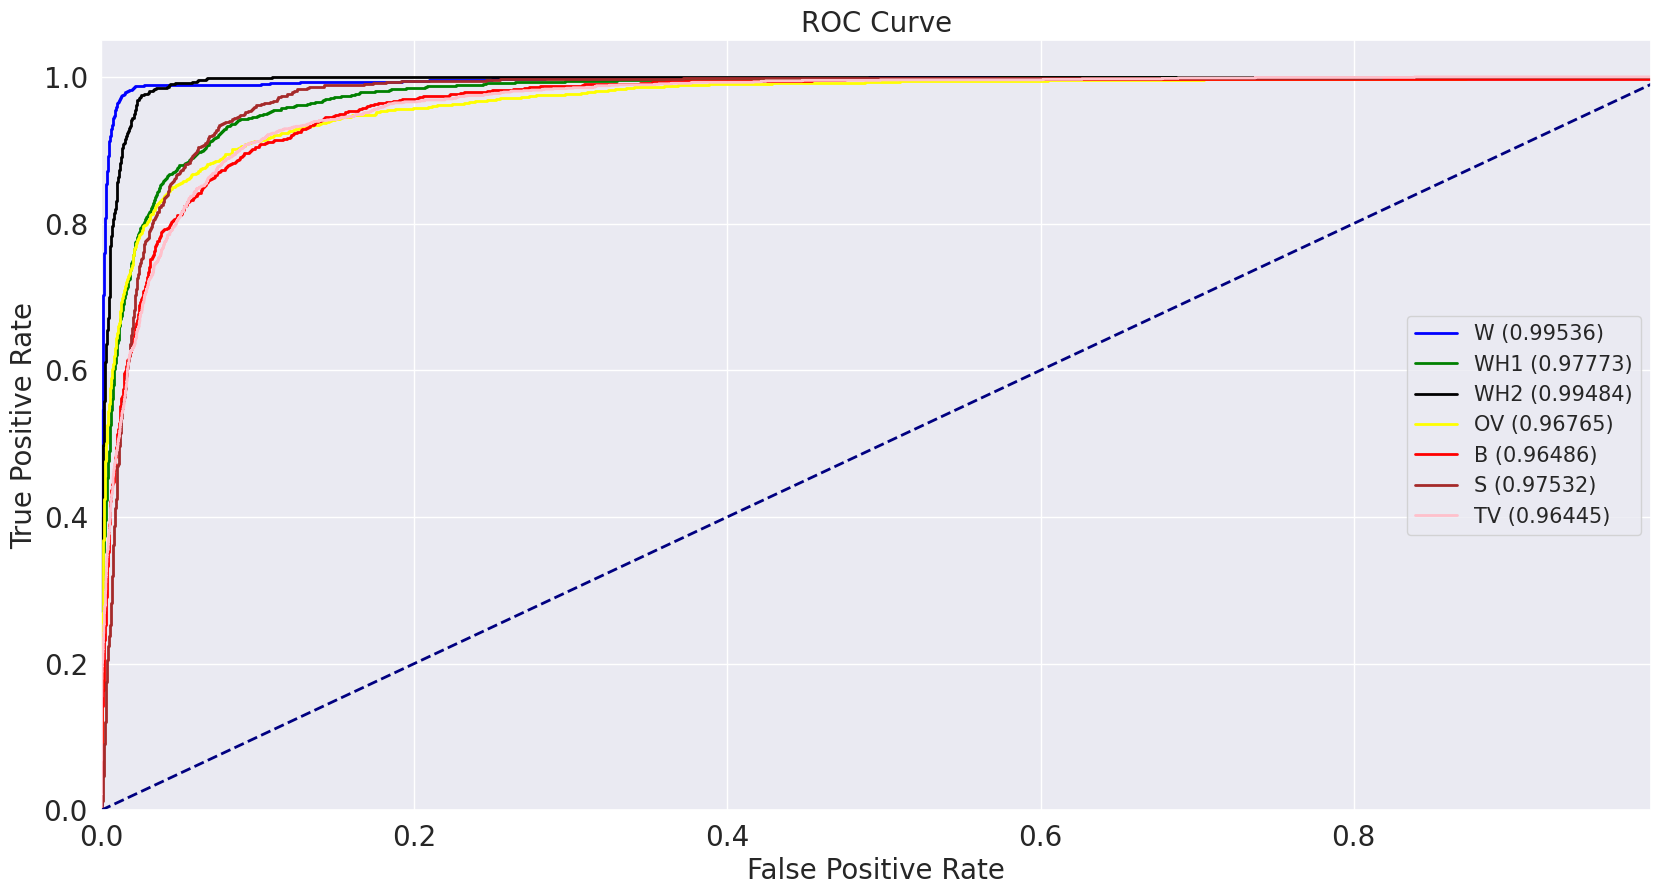

In [126]:
plt.figure(figsize=(20, 10))

for idx, lbl in enumerate(class_labels):
    if np.isnan(roc_auc[idx]):
        continue
    plt.plot(fpr[idx], tpr[idx], color=lulc_cmap.colors[lbl],
             lw=2, label=class_names[lbl] + ' (%0.5f)' % roc_auc[idx])


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 0.99])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('ROC Curve', fontsize=20)
plt.legend(loc="center right", prop={'size': 15})
plt.show()

In [128]:
datadirectory='/space/vak/Weedwatch/Patancheru/Drone/Images/'
imagefile_1 = 'Orthomosaic_26Mar2021_PatanCheru_AOI_10cm.tif'
(img1, crs, geoTransform) = read_band_image(datadirectory,imagefile_1)



In [129]:
# Take our full image,  and reshape into long 2d array (nrow * ncol, nband) for classification
img5 = img1[:,:, :5]
new_shape = (img5.shape[0] * img5.shape[1], img5.shape[2])

img_as_array = img5.reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=img5.shape,
                                        n=img_as_array.shape))

# Now predict for each pixel
class_prediction = model.predict(img_as_array)

Reshaped from (12954, 8550, 5) to (110756700, 5)


In [130]:
# Reshape our classification map
class_prediction = class_prediction.reshape(img5[:, :, 0].shape)

In [131]:
#class_prediction = class_prediction * mask

Text(0.5, 1.0, 'Classification')

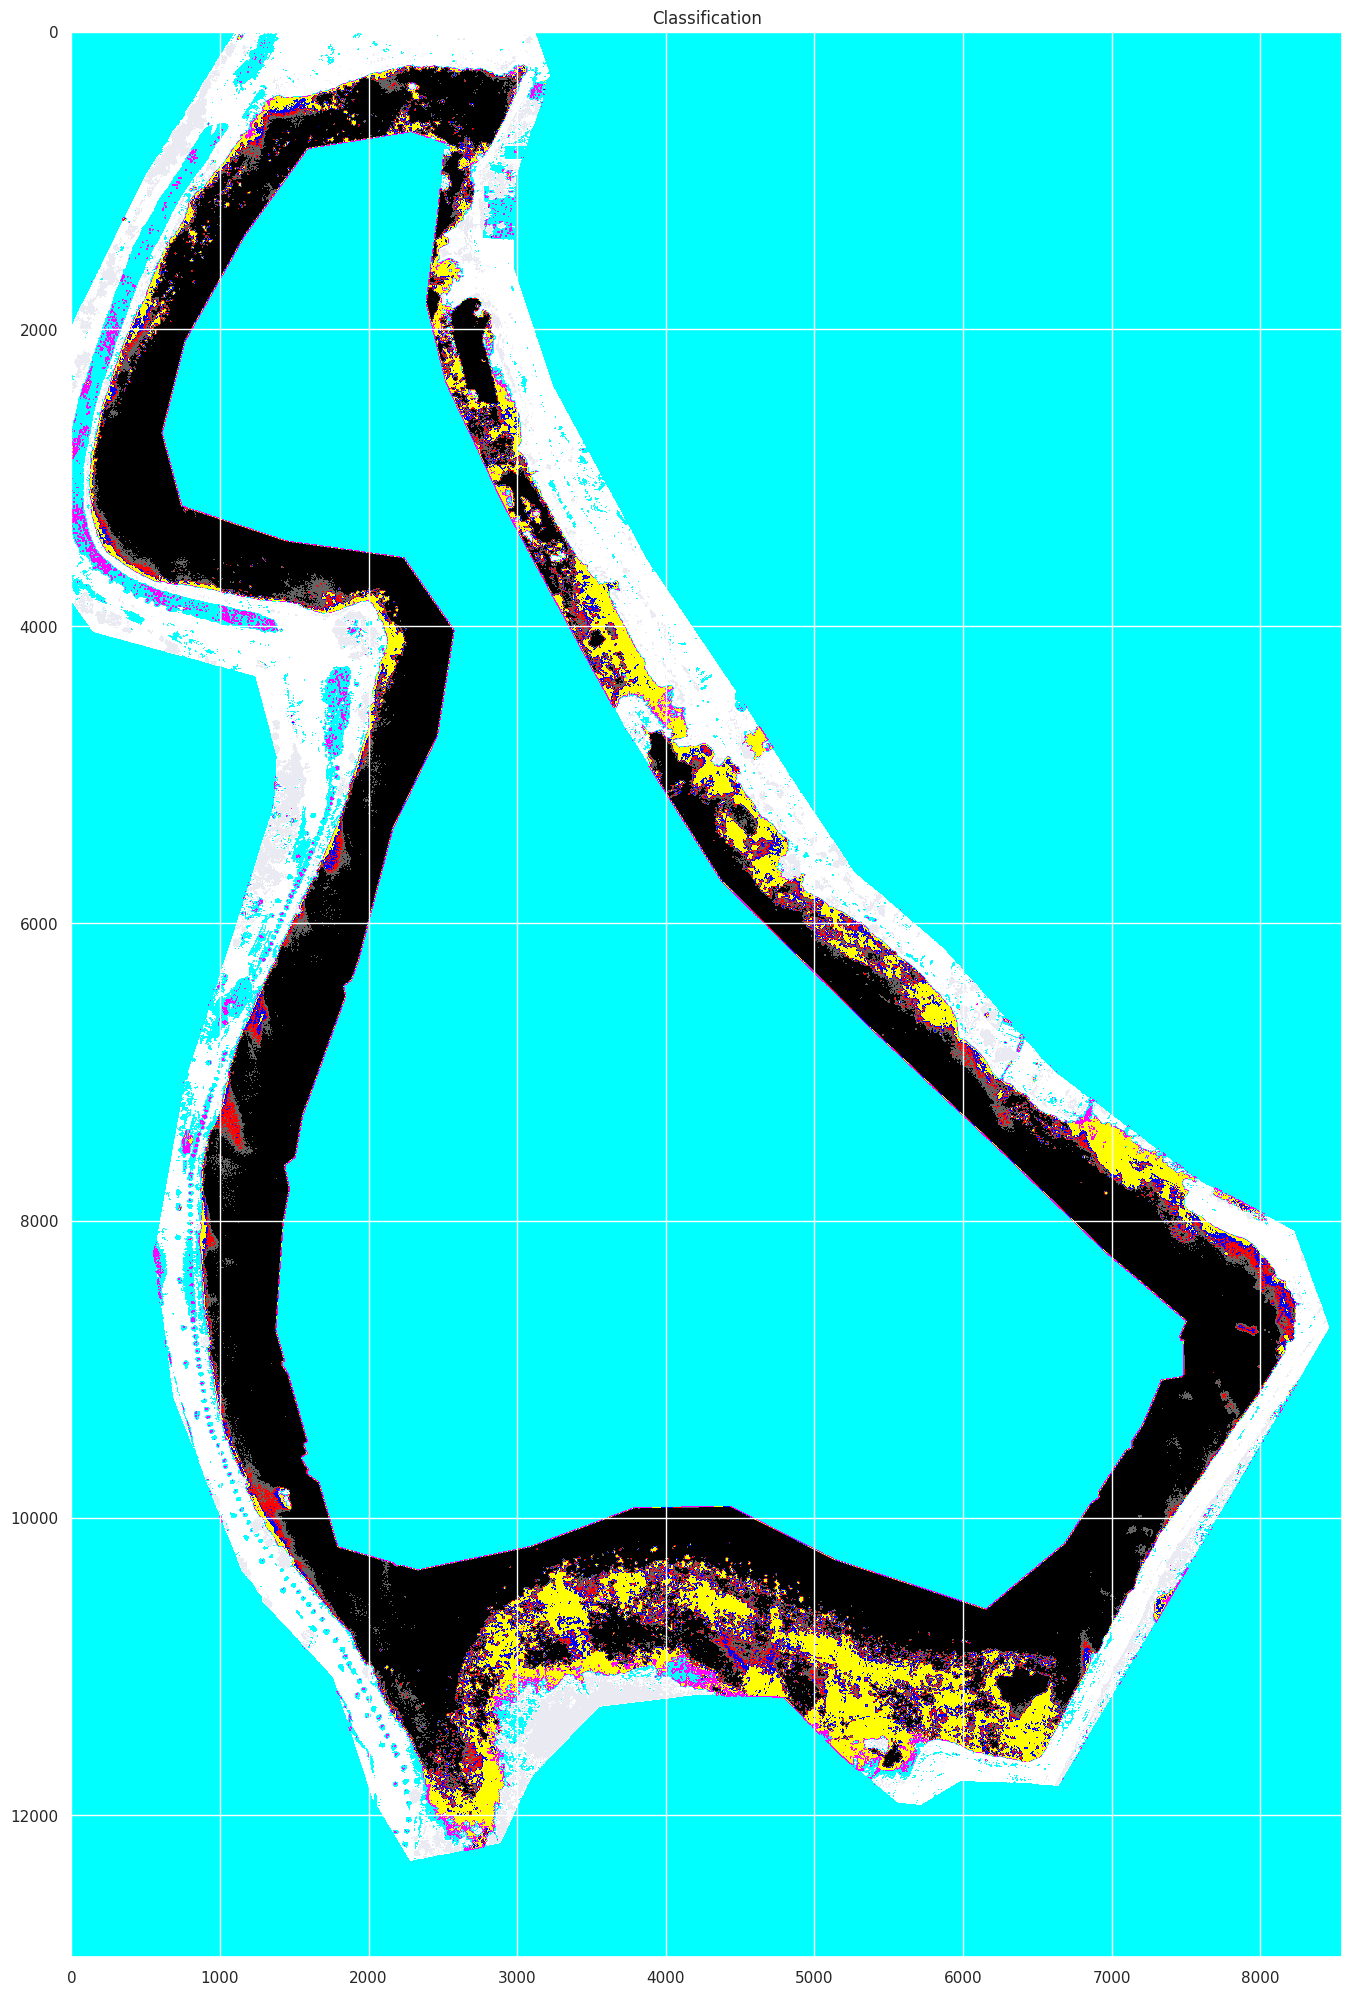

In [132]:
# Visualize
# Now show the classmap next to the image
f = plt.figure(figsize=(20,25))
ax1 = f.add_subplot(111)



ax1.imshow(class_prediction,cmap=cmap)
ax1.set_title('Classification')


In [133]:
import rasterio
with rasterio.open(
        "/space/vak/Weedwatch/Patancheru/Drone/CLSs/26Mar2021_cls.tif",
        mode="w",
        driver="GTiff",
        height=class_prediction.shape[0],
        width=class_prediction.shape[1],
        count=1,
        dtype=class_prediction.dtype,
        crs=crs,
        transform=geoTransform,
) as new_dataset:
        new_dataset.write(class_prediction, 1)


ERROR 1: PROJ: proj_create_from_name: /home/vak/anaconda3/envs/myenv/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [62]:
pwd

'/space/vak/Weedwatch/Patancheru/Drone/Images'